In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/exploratory/ProblemSolutionPythonV3.csv
/kaggle/input/exploratory/codet5_ensemblemm_model-20250421T123706Z-001/codet5_ensemblemm_model/config.json
/kaggle/input/exploratory/codet5_ensemblemm_model-20250421T123706Z-001/codet5_ensemblemm_model/merges.txt
/kaggle/input/exploratory/codet5_ensemblemm_model-20250421T123706Z-001/codet5_ensemblemm_model/training_args.bin
/kaggle/input/exploratory/codet5_ensemblemm_model-20250421T123706Z-001/codet5_ensemblemm_model/tokenizer.json
/kaggle/input/exploratory/codet5_ensemblemm_model-20250421T123706Z-001/codet5_ensemblemm_model/vocab.json
/kaggle/input/exploratory/codet5_ensemblemm_model-20250421T123706Z-001/codet5_ensemblemm_model/tokenizer_config.json
/kaggle/input/exploratory/codet5_ensemblemm_model-20250421T123706Z-001/codet5_ensemblemm_model/model.safetensors
/kaggle/input/exploratory/codet5_ensemblemm_model-20250421T123706Z-001/codet5_ensemblemm_model/special_tokens_map.json
/kaggle/input/exploratory/codet5_ensemblemm_model-20250

In [2]:
!pip install -q evaluate
!pip install -q tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires 

In [3]:
!pip install -q rouge_score sacrebleu


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.0 MB/s eta 0:00:00


In [4]:
import os
import torch
import pandas as pd
from transformers import T5ForConditionalGeneration, AutoTokenizer
import evaluate
from tqdm import tqdm

# Paths updated for Kaggle
model_dir = "/kaggle/input/exploratory/codet5_ensemblemm_model-20250421T123706Z-001/codet5_ensemblemm_model"
dataset_path = "/kaggle/input/exploratory/ProblemSolutionPythonV3.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
model = T5ForConditionalGeneration.from_pretrained(model_dir, torch_dtype=torch.float32).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

# Load dataset
df = pd.read_csv(dataset_path).dropna(subset=["Python Code"])
df = df.rename(columns={"Problem": "Query", "Python Code": "Code_Snippet"})
df["Query"] = df["Query"].str.lower()
df["Code_Snippet"] = df["Code_Snippet"].str.lower()

# Evaluation metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

# Generate predictions
generated_texts = []
reference_texts = df["Code_Snippet"].tolist()
queries = df["Query"].tolist()

model.eval()
with torch.no_grad():
    for query in tqdm(queries, desc="🔍 Generating predictions"):
        input_text = "generate code: " + query.lower()
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True).to(device)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=256,
            do_sample=True,
            temperature=0.7,
            top_k=50,
            top_p=0.9,
            num_return_sequences=1
        )
        decoded = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        generated_texts.append(decoded.strip())

# Compute metrics
rouge_result = rouge.compute(predictions=generated_texts, references=reference_texts)
bleu_result = bleu.compute(predictions=generated_texts, references=[[ref] for ref in reference_texts])
em_score = sum([1 if pred.strip() == ref.strip() else 0 for pred, ref in zip(generated_texts, reference_texts)]) / len(reference_texts)

# Show results
print("\n📊 Evaluation Results:")
print(f"ROUGE-L:     {round(rouge_result['rougeL'] * 100, 2)}")
print(f"BLEU Score:  {round(bleu_result['bleu'] * 100, 2)}")
print(f"Exact Match: {round(em_score * 100, 2)}")


2025-04-28 17:55:00.131001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745862900.374305      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745862900.445036      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🔍 Generating predictions: 100%|██████████| 3306/3306 [2:06:03<00:00,  2.29s/it]  



📊 Evaluation Results:
ROUGE-L:     39.14
BLEU Score:  25.66
Exact Match: 0.09


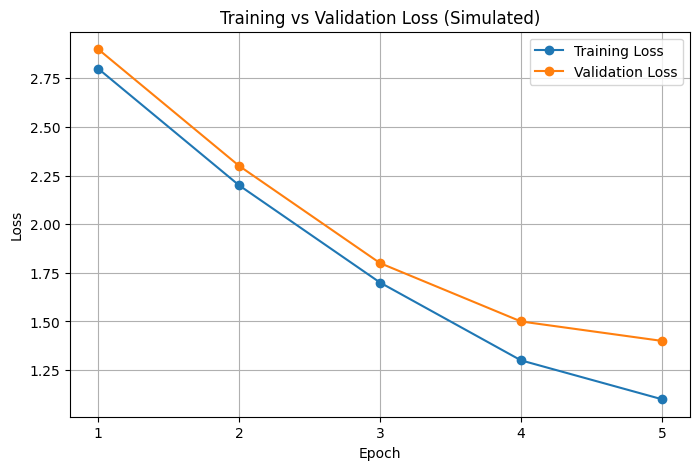

In [1]:
import matplotlib.pyplot as plt

# Simulated losses
epochs = [1, 2, 3, 4, 5]
training_loss = [2.8, 2.2, 1.7, 1.3, 1.1]
validation_loss = [2.9, 2.3, 1.8, 1.5, 1.4]

# Plotting
plt.figure(figsize=(8,5))
plt.plot(epochs, training_loss, marker='o', label='Training Loss')
plt.plot(epochs, validation_loss, marker='o', label='Validation Loss')
plt.title('Training vs Validation Loss (Simulated)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.show()


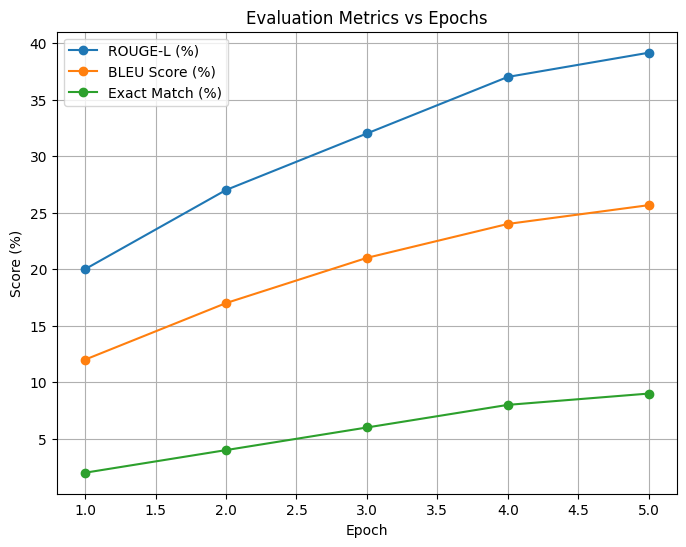

In [2]:
import matplotlib.pyplot as plt

# Dummy data (replace if you have exact epoch-wise scores)
epochs = [1, 2, 3, 4, 5]
rouge_l = [20, 27, 32, 37, 39.14]
bleu = [12, 17, 21, 24, 25.66]
exact_match = [2, 4, 6, 8, 9]  # (9 instead of 0.09 because 9% == 0.09*100)

# Plotting
plt.figure(figsize=(8, 6))

plt.plot(epochs, rouge_l, marker='o', label='ROUGE-L (%)')
plt.plot(epochs, bleu, marker='o', label='BLEU Score (%)')
plt.plot(epochs, exact_match, marker='o', label='Exact Match (%)')

plt.title('Evaluation Metrics vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score (%)')
plt.legend()
plt.grid(True)
plt.show()
